# Evolution Gates

PR #6975: github.com/Qiskit/qiskit-terra/pull/6975

Time evolution of an Hamiltonian or operator $H$ (here: $H$ only as sums of Paulis):

$$
    U(t) = e^{iHt}
$$

**Trotterization** Time evolution of a quantum state $U(t)|\Psi_0\rangle$

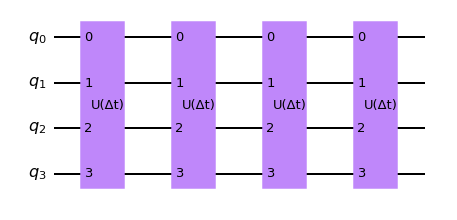

**Ground state calculation** Ansatz circuits using evolutions, like UCCSD or QAOA.

## Time evolution in Qiskit today

In [1]:
from qiskit.opflow import I, X, Z

time = 0.01
H = -(Z ^ Z ^ I) - (I ^ Z ^ Z) - (X ^ I ^ I) - (I ^ X ^ I) - (I ^ I ^ X)

Use Opflow's `EvolutionBase` hierarchy:

In [2]:
from qiskit.opflow import PauliTrotterEvolution

evolution = PauliTrotterEvolution()

evolved_op = (time * H).exp_i()
circuit_op = evolution.convert(evolved_op)
circuit = circuit_op.primitive

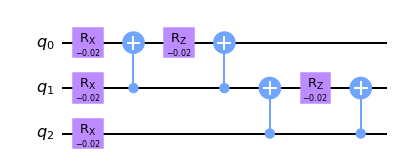

In [3]:
circuit.draw('mpl')

### Problems 

* Not straightforward to run!
* We miss out on optimizations:

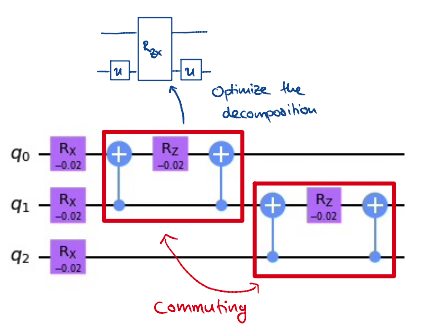

* The compiler might know better based on the Hardware / context

## New Evolution Gates

Delay the decomposition and let the compiler can select the optimal synthesis!

Input can be either a `SparsePauliOp`, `PauliSumOp` or lists thereof.

In [4]:
from qiskit.circuit.library.evolution import EvolutionGate

print(type(H))
evo_gate = EvolutionGate(H, time)

<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>


In [5]:
EvolutionGate([
    (Z ^ I) + (I ^ Z), 
    (X ^ X)
], time)

Default: Plain matrix exponentiation

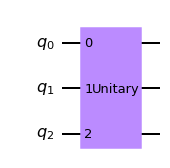

In [6]:
evo_gate.definition.draw('mpl')

Selecting product-formula based decomposition:

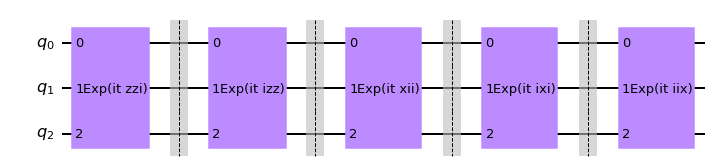

In [7]:
from qiskit.circuit.library.evolution import LieTrotter

synthesis = LieTrotter(insert_barriers=True)
evo_gate = EvolutionGate(H, time, synthesis=synthesis)
evo_gate.definition.draw('mpl')

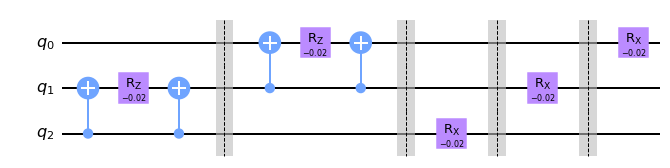

In [8]:
evo_gate.definition.decompose().draw('mpl')

Now we can check which gates are commuting (just check the Pauli strings) and it's easy to find and optimize the 2q evolutions.

### QAOA

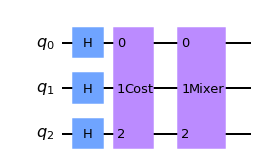

In [9]:
from qiskit.circuit import Parameter, QuantumCircuit

cost_operator = (Z ^ Z ^ I) + (I ^ Z ^ Z)
mixer_operator = (X ^ I ^ I) + (I ^ X ^ I) + (I ^ I ^ X)

gamma = Parameter('γ')
beta = Parameter('β')

mixer = EvolutionGate(mixer_operator, time=beta, label='Mixer')
cost = EvolutionGate(cost_operator, time=gamma, label='Cost')

qaoa = QuantumCircuit(3)
qaoa.h(range(3))
qaoa.compose(cost, range(3), inplace=True)
qaoa.compose(mixer, range(3), inplace=True)

qaoa.draw('mpl')

In your transpiler pass:

In [10]:
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qaoa)

for node in dag.op_nodes():
    if isinstance(node.op, EvolutionGate):
        print(f'Found an evolution over time {node.op.time} under operator {node.op.operator.to_list()}', '\n')

Found an evolution over time γ under operator [('ZZI', (1+0j)), ('IZZ', (1+0j))] 

Found an evolution over time β under operator [('XII', (1+0j)), ('IXI', (1+0j)), ('IIX', (1+0j))] 



### Adding more synthesis methods

By implementing the `EvolutionSynthesis` interface

In [11]:
from qiskit.circuit.library.evolution import EvolutionSynthesis

In [12]:
isinstance(LieTrotter(), EvolutionSynthesis)

True

Example:

In [13]:
class MyEfficientSynthesis(EvolutionSynthesis):
    def synthesize(self,
                   operators, # Union[SparsePauliOp, List[SparsePauliOp]],
                   time) -> QuantumCircuit:
        empty = QuantumCircuit(operators.num_qubits, name='i do nothing')
        evo = QuantumCircuit(operators.num_qubits)
        evo.append(empty, evo.qubits)
        return evo

In [14]:
evo_gate = EvolutionGate(H, time, synthesis=MyEfficientSynthesis())
evo_gate.definition.draw()

┌───────────────┐
q_0: ┤0              ├
     │               │
q_1: ┤1 i do nothing ├
     │               │
q_2: ┤2              ├
     └───────────────┘

## To do's

* Compiler flag to select synthesis
* Different evolution algorithms 
    * higher order Product Formula (in prep)
    * Linear Combination of Unitaries
* Improve labelling
* Automatic Pauli grouping

### UCCSD

In [15]:
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Pauli, SparsePauliOp

single_ops = [[('IIYX', (0.5+0j)), ('IIXY', (-0.5+0j))], 
              [('YXII', (0.5+0j)), ('XYII', (-0.5+0j))], 
              [('YXXX', (0.125+0j)), ('XYXX', (-0.125+0j)), ('XXYX', (0.125+0j)), ('YYYX', (0.125+0j)), ('XXXY', (-0.125+0j)), ('YYXY', (-0.125+0j)), ('YXYY', (0.125+0j)), ('XYYY', (-0.125+0j))]]
uccsd_ops = [SparsePauliOp.from_list(single_op) for single_op in single_ops]
parameters = ParameterVector('th', len(uccsd_ops))

In [16]:
uccsd = QuantumCircuit(4)
for param, op in zip(parameters, uccsd_ops):
    uccsd.append(EvolutionGate(op, time=param, synthesis=LieTrotter()), range(4))

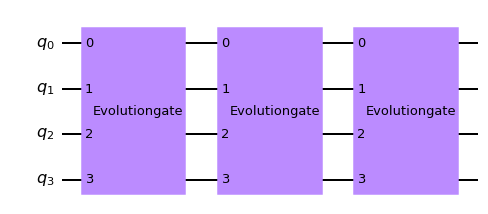

In [17]:
uccsd.draw('mpl')

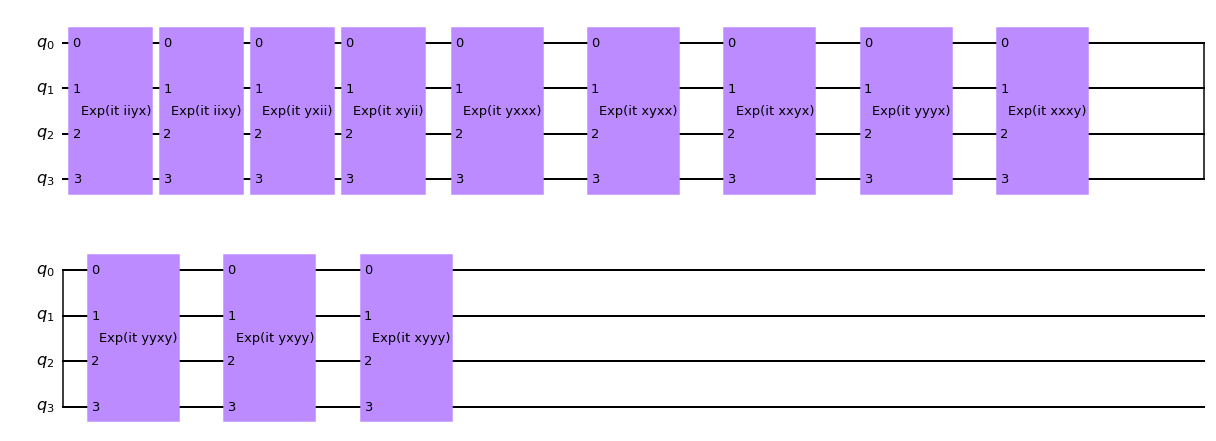

In [18]:
uccsd.decompose().draw('mpl')